## E-Commerce Order Distribution Optimization

This notebook is a documentation of the optimization of a delivery distribution system. It follows the process of importing necessary libraries , loading data , data cleaning and validation , the optimization algorithm, and visualizations of results.

## Problem Statement

An e-commerce company based in Lomé, Togo, serves customers throughout Ghana through multiple destination centers. Each center has a fleet of trucks that delivers orders to customers. The company faces efficiency issues in their distribution systems, which result in suboptimal truck utilization; that is, there is unequal load distribution amongst trucks.

## Overview of Dataset

1. Centres table : centreid , name and location
2. Orders table : order details , truck key and order status
3. Trucks table : truck key , truck type and truck capacity in kg


### order distribution optimization goals 

At the end of this, I hope to provide solutions for: 
1. making pending orders a priority
2. Handling truck delays 
3. Equal truckload distribution

#### Importance of efficiency in delivery systems 
Distribution efficiency is important because it directly impacts profit, customer satisfaction, and and market competition while also reducing operational costs and improving sales .

### Metabase Insights 

1. There are a total of 35 trucks, out of which 5 are inactive and 30 are active. I also noticed that box trucks make up the majority of the fleet.
2. There are a total of five warehouses, of which Accra receives the bulk of orders .
3. The company has sold about 526,945 orders over the years and made approximately 2.6 billion in revenue over time.
4. There is also a backlog amounting to about 310,775 pending orders over time.
5. Also notice the comparison of the number of orders a truck takes as compared to its capacity, showing unequal load distribution.

#### 1. Data Preprocessing

#### Importing necessary libraries

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")

print("Essential libraries imported")


Essential libraries imported


#### Load Data

In [40]:
orders = pd.read_csv(r"C:\Users\Yaa\Desktop\yaa's personal projects\affinity labs data technical\orders.csv")
trucks = pd.read_csv(r"C:\Users\Yaa\Desktop\yaa's personal projects\affinity labs data technical\trucks.csv")
centers = pd.read_csv(r"C:\Users\Yaa\Desktop\yaa's personal projects\affinity labs data technical\centres.csv") 

print("Data loaded successfully!")
print(f"Orders shape: {orders.shape}, Trucks shape: {trucks.shape}, Centers shape: {centers.shape}")


Data loaded successfully!
Orders shape: (526945, 11), Trucks shape: (35, 5), Centers shape: (5, 3)


#### Data Inspection

In [42]:
print("\nMissing Values Check:")
print("Orders:")
print(orders.isnull().sum())
print("\nTrucks:")
print(trucks.isnull().sum())
print("\nCenters:")
print(centers.isnull().sum())

print("\nDuplicate Check:")
print(f"Duplicate orders: {orders.duplicated().sum()}")
print(f"Duplicate trucks: {trucks.duplicated().sum()}")
print(f"Duplicate centers: {centers.duplicated().sum()}")


Missing Values Check:
Orders:
Unnamed: 0            0
orderId               0
clientId           1243
lastModified          0
status                0
truckKey         310775
location              0
fee                   0
volume(kg)            0
deliveryItem          0
dateGenerated         0
dtype: int64

Trucks:
creationDate    0
encodedKey      0
status          0
truckType       0
volume(kg)      0
dtype: int64

Centers:
centreId        0
location        0
creationDate    0
dtype: int64

Duplicate Check:
Duplicate orders: 0
Duplicate trucks: 0
Duplicate centers: 0


#### Data Cleaning

In [68]:
#  Handling Missing Values
orders['clientId'] = orders['clientId'].fillna('Unknown')

#  Validating PENDING orders
pending_mask = orders['status'] == 'PENDING'
assert orders[pending_mask]['truckKey'].isnull().all(), "Some PENDING orders have truck keys!"

# Fixing Data Types
date_cols = ['lastModified', 'dateGenerated']
orders[date_cols] = orders[date_cols].apply(pd.to_datetime)

trucks['creationDate'] = pd.to_datetime(trucks['creationDate'])
trucks['volume(kg)'] = trucks['volume(kg)'].astype(float)

centers['creationDate'] = pd.to_datetime(centers['creationDate'])

# Removing Unnecessary Columns
orders.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

#### Data Validation

In [48]:
print("\nFinal Data Types:")
print("Orders:")
print(orders.dtypes)
print("\nTrucks:")
print(trucks.dtypes)
print("\nCenters:")
print(centers.dtypes)


Final Data Types:
Orders:
Unnamed: 0         int64
orderId           object
clientId          object
lastModified      object
status            object
truckKey          object
location          object
fee              float64
volume(kg)       float64
deliveryItem      object
dateGenerated     object
dtype: object

Trucks:
creationDate    object
encodedKey      object
status          object
truckType       object
volume(kg)       int64
dtype: object

Centers:
centreId         int64
location        object
creationDate    object
dtype: object


#### Saving clean Data

In [52]:
# Create output directory if it doesn't exist
os.makedirs('transformed_data', exist_ok=True)

# Save cleaned data
orders.to_csv('transformed_data/orders.csv', index=False)
trucks.to_csv('transformed_data/trucks.csv', index=False)
centers.to_csv('transformed_data/centres.csv', index=False)
pending_orders = orders[orders['status'] == 'PENDING']
pending_orders.to_csv('transformed_data/pending_orders.csv', index=False)

####

#### 2. Optimization

In [54]:
# Optimization Configuration

CONFIG = {
    'TRUCK_CAPACITIES': {
        'REEFER_TRUCK': 20000,  # kg
        'BOX_TRUCK': 15000       # kg 
    },
    'TARGET_UTILIZATION': 0.80,  # target set to 80%
    'MAX_UTILIZATION': 0.85       # the maximum we are willing to allow 85%
}

In [56]:
# Data Preparation

# Filter active trucks and pending orders
active_trucks = trucks[trucks['status'] == 'ACTIVE'].copy()
pending_orders = orders[orders['status'] == 'PENDING'].copy()

# summary 
print(f"Active trucks available: {len(active_trucks)}")
print(f"Pending orders to allocate: {len(pending_orders):,}")
print(f"Total pending volume (kg): {pending_orders['volume(kg)'].sum():,.0f}")

Active trucks available: 30
Pending orders to allocate: 310,775
Total pending volume (kg): 26,882,387


In [58]:
# Capacity Analysis

def calculate_capacity(trucks_df):
    capacity = {}
    for truck_type, capacity_kg in CONFIG['TRUCK_CAPACITIES'].items():
        count = sum(trucks_df['truckType'] == truck_type)
        capacity[truck_type] = {
            'available': count,
            'target_capacity': count * capacity_kg * CONFIG['TARGET_UTILIZATION'],
            'max_capacity': count * capacity_kg * CONFIG['MAX_UTILIZATION']
        }
    return pd.DataFrame(capacity).T

capacity_report = calculate_capacity(active_trucks)
print("\nCurrent Fleet Capacity:")
print(capacity_report[['available', 'target_capacity', 'max_capacity']])


Current Fleet Capacity:
              available  target_capacity  max_capacity
REEFER_TRUCK        5.0          80000.0       85000.0
BOX_TRUCK          25.0         300000.0      318750.0


####

#### Order Allocation Algorithm

Assigns orders to trucks using largest-first approach
Returns: assignments DataFrame, remaining orders

In [76]:
# Order Allocation

def allocate_orders(orders, trucks):
    
    # Sort orders by size (largest first)
    sorted_orders = orders.sort_values('volume(kg)', ascending=False).copy()
    
    # Calculate truck capacities
    trucks = trucks.copy()
    trucks['target_kg'] = trucks['volume(kg)'] * CONFIG['TARGET_UTILIZATION']
    trucks['max_kg'] = trucks['volume(kg)'] * CONFIG['MAX_UTILIZATION']
    
    results = []
    
    for _, truck in trucks.iterrows():
        truck_orders = []
        loaded_kg = 0
        
        for idx, order in sorted_orders.iterrows():
            potential_load = loaded_kg + order['volume(kg)']
            
            if potential_load <= truck['max_kg']:
                truck_orders.append(order)
                loaded_kg = potential_load
                sorted_orders = sorted_orders.drop(idx)
                
                if loaded_kg >= truck['target_kg']:
                    break
        
        if truck_orders:
            util = loaded_kg / truck['volume(kg)']
            results.append({
                'truck': truck['encodedKey'],
                'type': truck['truckType'],
                'order_count': len(truck_orders),
                'loaded_kg': loaded_kg,
                'utilization': util,
                'status': 'OPTIMAL' if util >= CONFIG['TARGET_UTILIZATION'] else 'UNDERUTILIZED'
            })
    
    return pd.DataFrame(results), sorted_orders

# Execute allocation
assignments, remaining_orders = allocate_orders(pending_orders, active_trucks)

# Print results
print(f"\nAssigned {len(assignments)} trucks ({assignments['order_count'].sum():,} orders)")
print(f"Remaining orders: {len(remaining_orders):,}")
print(f"Average utilization: {assignments['utilization'].mean():.1%}")


Assigned 30 trucks (1,002 orders)
Remaining orders: 309,773
Average utilization: 81.3%


####

#### Visualizations

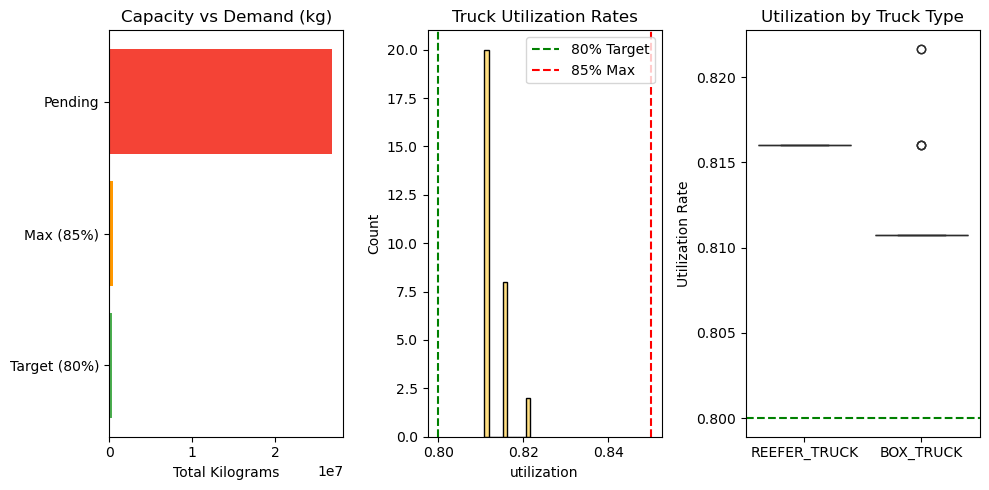

In [77]:
# Results Visualization

plt.figure(figsize=(10, 5))


# 1. Capacity vs Demand Comparison

plt.subplot(1, 3, 1)
plt.barh(['Target (80%)', 'Max (85%)', 'Pending'],
         [capacity_report['target_capacity'].sum(),
          capacity_report['max_capacity'].sum(),
          pending_orders['volume(kg)'].sum()],
         color=['#4CAF50', '#FF9800', '#F44336'])
plt.title("Capacity vs Demand (kg)")
plt.xlabel("Total Kilograms")


# 2. Utilization Distribution

plt.subplot(1, 3, 2)
sns.histplot(data=assignments, x='utilization', bins=10, 
             hue='status', palette=['#FFC107', '#4CAF50'])
plt.axvline(CONFIG['TARGET_UTILIZATION'], color='green', linestyle='--', label='80% Target')
plt.axvline(CONFIG['MAX_UTILIZATION'], color='red', linestyle='--', label='85% Max')
plt.title("Truck Utilization Rates")
plt.legend()


# 3. Utilization by Truck Type

plt.subplot(1, 3, 3)
sns.boxplot(data=assignments, x='type', y='utilization',
            palette=['#2196F3', '#009688'])
plt.axhline(CONFIG['TARGET_UTILIZATION'], color='green', linestyle='--')
plt.title("Utilization by Truck Type")
plt.ylabel("Utilization Rate")
plt.xlabel("")

plt.tight_layout()
plt.show()

In [25]:
print(f"SCALING REQUIREMENTS:\n"
      f"Base capacity: {capacity_report['target_capacity'].sum():,.0f} kg\n"
      f"Pending volume: {pending_orders['volume(kg)'].sum():,.0f} kg\n"
      f"Required expansion: +{pending_orders['volume(kg)'].sum() - capacity_report['target_capacity'].sum():,.0f} kg")

SCALING REQUIREMENTS:
Base capacity: 380,000 kg
Pending volume: 26,882,387 kg
Required expansion: +26,502,387 kg


####

#### Fleet expansion calculator

In [78]:
# Fleet Expansion Calculator

# Current fleet counts
current_box_trucks = sum(active_trucks['truckType'] == 'BOX_TRUCK')
current_reefers = sum(active_trucks['truckType'] == 'REEFER_TRUCK')

# Capacity calculations (80% utilization, 4 trips/month)
BOX_TRUCK_MONTHLY_KG = 15000 * 0.80 * 4  # 48,000 kg/month
REEFER_MONTHLY_KG = 20000 * 0.80 * 4     # 64,000 kg/month

# Calculate required additional capacity
current_capacity = (current_box_trucks * BOX_TRUCK_MONTHLY_KG) + \
                   (current_reefers * REEFER_MONTHLY_KG)
required_kg = pending_orders['volume(kg)'].sum() - current_capacity

def calculate_expansion(kg_needed):
    """Calculate truck requirements for different strategies"""
    # Box trucks only
    box_only = {
        'box_trucks': round(kg_needed / BOX_TRUCK_MONTHLY_KG),
        'reefers': 0,
        'total_capacity': round(kg_needed / BOX_TRUCK_MONTHLY_KG) * BOX_TRUCK_MONTHLY_KG
    }
    
    # Reefers only
    reefer_only = {
        'box_trucks': 0,
        'reefers': round(kg_needed / REEFER_MONTHLY_KG),
        'total_capacity': round(kg_needed / REEFER_MONTHLY_KG) * REEFER_MONTHLY_KG
    }
    
    # Balanced mix (80% box / 20% reefer)
    mixed_capacity = (0.8 * BOX_TRUCK_MONTHLY_KG) + (0.2 * REEFER_MONTHLY_KG)
    balanced = {
        'box_trucks': round(0.8 * (kg_needed / mixed_capacity)),
        'reefers': round(0.2 * (kg_needed / mixed_capacity)),
        'total_capacity': round(kg_needed / mixed_capacity) * mixed_capacity
    }
    
    return {
        'box_only': box_only,
        'reefer_only': reefer_only,
        'balanced': balanced
    }

expansion_options = calculate_expansion(required_kg)

# Set the expanded capacity (we'll use the balanced scenario)
expanded_capacity = current_capacity + expansion_options['balanced']['total_capacity']

# Display results
print(f"\nCURRENT FLEET CAPACITY: {current_capacity/1e6:.1f}M kg/month")
print(f"ADDITIONAL CAPACITY NEEDED: {required_kg/1e6:.1f}M kg/month")

for strategy, trucks in expansion_options.items():
    print(f"\n{strategy.upper().replace('_', ' ')} SCENARIO:")
    print(f"- Add {trucks['box_trucks']} box trucks")
    print(f"- Add {trucks['reefers']} reefer trucks")
    print(f"- New capacity: +{trucks['total_capacity']/1e6:.1f}M kg/month")
    print(f"- Total capacity: {(current_capacity + trucks['total_capacity'])/1e6:.1f}M kg/month")

print(f"\nSELECTED EXPANDED CAPACITY: {expanded_capacity/1e6:.1f}M kg/month")


CURRENT FLEET CAPACITY: 1.5M kg/month
ADDITIONAL CAPACITY NEEDED: 25.4M kg/month

BOX ONLY SCENARIO:
- Add 528 box trucks
- Add 0 reefer trucks
- New capacity: +25.3M kg/month
- Total capacity: 26.9M kg/month

REEFER ONLY SCENARIO:
- Add 0 box trucks
- Add 396 reefer trucks
- New capacity: +25.3M kg/month
- Total capacity: 26.9M kg/month

BALANCED SCENARIO:
- Add 396 box trucks
- Add 99 reefer trucks
- New capacity: +25.3M kg/month
- Total capacity: 26.9M kg/month

SELECTED EXPANDED CAPACITY: 26.9M kg/month


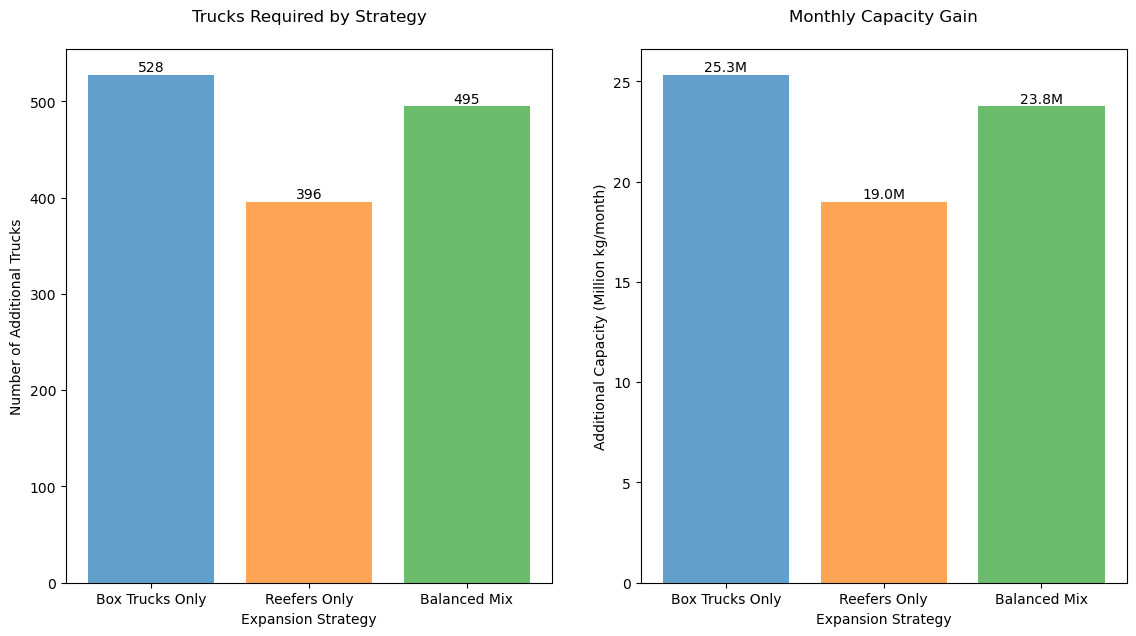

In [29]:
# Fleet Expansion Visualization

plt.figure(figsize=(12, 7))

# Preparing data
strategies = ['Box Trucks Only', 'Reefers Only', 'Balanced Mix']
truck_counts = [
    expansion_options['box_only']['box_trucks'],  # Box trucks only
    expansion_options['reefer_only']['reefers'],  # Reefers only
    (expansion_options['balanced']['box_trucks'] +  # Balanced total
     expansion_options['balanced']['reefers'])
]

cost_ratios = [1.0, 1.5, 1.2]  # Relative cost factors (example)

# subplots
ax1 = plt.subplot(1, 2, 1)
bars = ax1.bar(strategies, truck_counts, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c'],
               alpha=0.7)

ax1.set_title('Trucks Required by Strategy', pad=20)
ax1.set_ylabel('Number of Additional Trucks')
ax1.set_xlabel('Expansion Strategy')

# data labels
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom')

# Second subplot - Capacity comparison
ax2 = plt.subplot(1, 2, 2)
capacity_values = [x * BOX_TRUCK_MONTHLY_KG/1000000 for x in truck_counts]  # in million kg
ax2.bar(strategies, capacity_values,
        color=['#1f77b4', '#ff7f0e', '#2ca02c'],
        alpha=0.7)

ax2.set_title('Monthly Capacity Gain', pad=20)
ax2.set_ylabel('Additional Capacity (Million kg/month)')
ax2.set_xlabel('Expansion Strategy')

# data labels
for i, bar in enumerate(ax2.patches):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}M',
            ha='center', va='bottom')

plt.tight_layout(pad=3.0)
plt.show()

####

####

#### Part 3

In [79]:
# Simulation Function (Updated)

def simulate_order_fulfillment(order_backlog, monthly_capacity, max_months=12):
    
    backlog = order_backlog.copy()
    monthly_results = []
    
    for month in range(1, max_months + 1):
        # Calculate value density (revenue per kg)
        backlog['value_density'] = backlog['fee'] / backlog['volume(kg)']
        
        # Sort by value density and order date
        backlog = backlog.sort_values(
            ['value_density', 'dateGenerated'], 
            ascending=[False, True]
        )
        
        # Process orders
        fulfilled = []
        current_load = 0
        
        for idx, order in backlog.iterrows():
            if current_load + order['volume(kg)'] <= monthly_capacity:
                fulfilled.append(idx)
                current_load += order['volume(kg)']
            else:
                break  # Stop when capacity reached
                
        # Update records
        fulfilled_orders = backlog.loc[fulfilled]
        backlog = backlog.drop(fulfilled)
        
        monthly_results.append({
            'month': month,
            'kg_fulfilled': current_load,
            'kg_remaining': backlog['volume(kg)'].sum(),
            'utilization': current_load / monthly_capacity,
            'orders_fulfilled': len(fulfilled_orders),
            'revenue_generated': fulfilled_orders['fee'].sum()
        })
        
        if backlog.empty:
            break
            
    return pd.DataFrame(monthly_results), backlog


print(f"Starting simulation with {len(pending_orders):,} pending orders")
print(f"Monthly capacity: {expanded_capacity:,.0f} kg")

results, remaining = simulate_order_fulfillment(
    pending_orders,
    monthly_capacity=expanded_capacity
)

Starting simulation with 310,775 pending orders
Monthly capacity: 26,864,000 kg


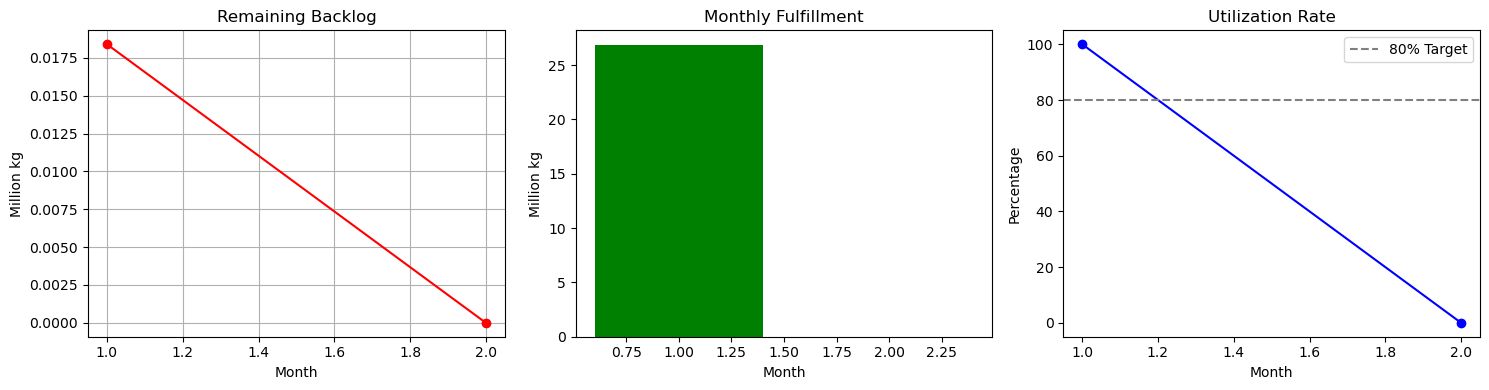


SIMULATION SUMMARY
-----------------
Time to clear backlog: 2 months
Total fulfilled: 26.9M kg
Average utilization: 50.0%
Revenue generated: $513.6M
Orders remaining: 0 (0.0%)


In [80]:
# Visualization 

plt.figure(figsize=(15, 4))

# Plot 1: Backlog Over Time
plt.subplot(1, 3, 1)
plt.plot(results['month'], results['kg_remaining']/1e6, 'r-o')
plt.title('Remaining Backlog')
plt.xlabel('Month')
plt.ylabel('Million kg')
plt.grid(True)

# Plot 2: Monthly Fulfillment
plt.subplot(1, 3, 2)
plt.bar(results['month'], results['kg_fulfilled']/1e6, color='green')
plt.title('Monthly Fulfillment')
plt.xlabel('Month')
plt.ylabel('Million kg')

# Plot 3: Utilization
plt.subplot(1, 3, 3)
plt.plot(results['month'], results['utilization']*100, 'b-o')
plt.axhline(80, color='gray', linestyle='--', label='80% Target')
plt.title('Utilization Rate')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.legend()

plt.tight_layout()
plt.show()

# Results Summary

print("\nSIMULATION SUMMARY")
print("-----------------")
print(f"Time to clear backlog: {len(results)} months")
print(f"Total fulfilled: {results['kg_fulfilled'].sum()/1e6:.1f}M kg")
print(f"Average utilization: {results['utilization'].mean():.1%}")
print(f"Revenue generated: ${results['revenue_generated'].sum()/1e6:.1f}M")
print(f"Orders remaining: {len(remaining):,} ({(len(remaining)/len(pending_orders)*100):.1f}%)")

#### Recommendations

1. #### Load Based Truck Assignment
   Using a load balancing system that uses a rule-based model to assign trucks based on capacity and the number of pending orders per center to ensure trucks are loaded as close to their capacity as possible.
2. #### Standardizing truck assignment Processes
   Setting validation rules in the delivery system where orders marked as pending must have a truck key and also introducing a daily check system to catch orders without truck key assignments.
3. ### Introduce a real time monitoring dashboard
   Deploying a real-time dashboard using Metabase to monitor status updates , track truck usage, and alert the logistics team when a truck is loaded according to each truck's capacity.
4. #### Cleaning and standardizing data entry.
   Making sure data is valid to avoid missing truck keys and unassigned orders .